In [1]:
import pandas as pd
import glob
import os
import regex as re
import string
import itertools
import docx2txt
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize
from spacy.lang.id import Indonesian
from html import unescape
from unidecode import unidecode
import pandas as pd
from string import punctuation
from bz2 import BZ2File as bz2
import numpy as np
from textblob import TextBlob 
import time
import seaborn as sns
import datetime
import spacy
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from tqdm import tqdm
from textblob import TextBlob
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from spacy.lang.id import Indonesian
#from spacy.lang.id.stop_words import STOP_WORDS
import warnings; warnings.simplefilter('ignore')
import TextMining as tm
import CleanText as ct

In [2]:
df = pd.read_csv("..\Data\Data Label\comments_Label_2000.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Video_Id     2000 non-null   object 
 1   Tittle       2000 non-null   object 
 2   Name         2000 non-null   object 
 3   Comment      2000 non-null   object 
 4   Comment_Id   2000 non-null   object 
 5   Time         2000 non-null   object 
 6   Likes        2000 non-null   int64  
 7   Reply_Count  1647 non-null   float64
 8   Label        2000 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 140.8+ KB


In [3]:
df["Label"] = df["Label"].astype("category")
df["Time"] = df["Time"].astype("datetime64")

In [4]:
df.head()

,Video_Id,Tittle,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label
0,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Banda vlog,Apa salah mobale lejen pak soekarno,UgwmjTHzY2zMOXBg9F94AaABAg,2019-04-11 11:27:47,0,0.0,legitimate
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,kharisma setya kencana,👆👆👆👆👆👆,UgzbICRmksoeoGVFCzd4AaABAg,2019-04-09 04:08:18,0,0.0,legitimate
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,「GratioKunz」,Dan golput itu apa,UgxROKiw4EX5LyaG0lx4AaABAg,2019-04-18 08:57:13,0,0.0,legitimate
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Trestrantara WZ,Keren!!,UgymN9o3cZFXVPLKcjZ4AaABAg,2019-04-08 16:42:13,0,0.0,legitimate
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Heri Kurniawan,Pilih siapa presiden aku Prabowo-Sandi,Ugw9J8lP4lOg0t5yX0l4AaABAg,2019-04-18 00:45:06,1,0.0,legitimate


In [5]:
df.isnull().sum()

Video_Id         0
Tittle           0
Name             0
Comment          0
Comment_Id       0
Time             0
Likes            0
Reply_Count    353
Label            0
dtype: int64

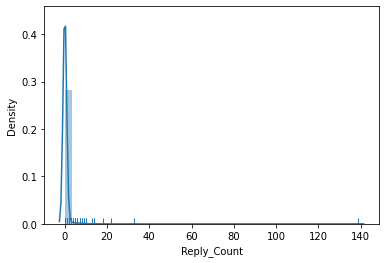

In [6]:
p = sns.distplot(df['Reply_Count'], kde=True, rug=True)

In [7]:
df['Reply_Count'].fillna(df['Reply_Count'].median(),inplace=True)

In [8]:
df.isnull().sum()

Video_Id       0
Tittle         0
Name           0
Comment        0
Comment_Id     0
Time           0
Likes          0
Reply_Count    0
Label          0
dtype: int64

In [9]:
df["Reply_Count"] = df["Reply_Count"].astype("int64")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Video_Id     2000 non-null   object        
 1   Tittle       2000 non-null   object        
 2   Name         2000 non-null   object        
 3   Comment      2000 non-null   object        
 4   Comment_Id   2000 non-null   object        
 5   Time         2000 non-null   datetime64[ns]
 6   Likes        2000 non-null   int64         
 7   Reply_Count  2000 non-null   int64         
 8   Label        2000 non-null   category      
dtypes: category(1), datetime64[ns](1), int64(2), object(5)
memory usage: 127.2+ KB


In [11]:
#count comments words length
def count_length(text):
    return len(text)

In [12]:
df['Length_Comment'] = df['Comment'].apply(lambda x: count_length(x))

In [13]:
df.sample(5)

,Video_Id,Tittle,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,Length_Comment
1069,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SMK Dinamika Kotabumi,Like like like biaaaaaaanget,Ugz7PyAccZINroniint4AaABAg,2019-04-11 10:15:07,0,0,legitimate,28
1225,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Nur Alan wahyu,Saya ambil buff,Ugy4-Qzj4ryE7B_1fiZ4AaABAg,2020-08-01 08:52:23,0,0,legitimate,15
802,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Devan Daily,bang atta lumaya tuh promo ahha @atta,UgxT5dUgrBVLL2nWItp4AaABAg,2019-04-09 07:48:54,1,1,legitimate,37
1766,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Robert Zm,Ternyata ada coki muslim,Ugz98Dz_IA6giDkGRKR4AaABAg,2020-06-13 08:21:06,0,0,legitimate,24
1361,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,pramana sanjaya,The real indonesia,Ugw1uWJ7X3fFEAe5fq54AaABAg,2019-04-08 15:05:04,0,0,legitimate,18


## EDA

### Comments that got most 

In [14]:
like = df[df['Likes']==df['Likes'].max()]
print("Komentar dengan like terbanyak adalah {}".format(like.iloc[0].Comment))

Komentar dengan like terbanyak adalah TERIMAKASIH SUDAH MENEMANI KAMI SEMUA SELAMA SEPULUH TAHUN

#thanksforskinnyindonesian24​


### 5 YouTube Account that comments have most reply

In [15]:
account = df['Name'].value_counts().head(5)
account = pd.DataFrame(data=account)
account.reset_index(inplace=True)
account = account.rename(columns = {"index" : "Youtube_Account",
                                    'Name': "reply_count"})
fig = px.bar(account, x='Youtube_Account', y='reply_count',
            color='Youtube_Account', title='10 YouTube Account that comments have most reply')
fig.show()

### Peak time to comments

In [16]:
data = df.copy()
times = data['Time']

In [17]:
def time(date):
    Time = date.time()
    return Time

data['Period'] = times.map(time)
data['Period'].head()

0    11:27:47
1    04:08:18
2    08:57:13
3    16:42:13
4    00:45:06
Name: Period, dtype: object

In [18]:
data1 = data.copy()

def time_groups(time):
    if time >= datetime.time(0,0) and time <= datetime.time(1,0):
        return '12 AM - 1 AM'
    elif time >= datetime.time(1,0) and time <= datetime.time(2,0):
        return '1 AM - 2 AM'
    elif time >= datetime.time(2,0) and time <= datetime.time(3,0):
        return '2 AM - 3 AM'
    elif time >= datetime.time(3,0) and time <= datetime.time(4,0):
        return '3 AM - 4AM'
    elif time >= datetime.time(4,0) and time <= datetime.time(5,0):
        return '4 AM - 5AM'
    elif time >= datetime.time(5,0) and time <= datetime.time(6,0):
        return '5 AM - 6 AM'
    elif time >= datetime.time(6,0) and time <= datetime.time(7,0):
        return '6 AM - 7 AM'
    elif time >= datetime.time(7,0) and time <= datetime.time(8,0):
        return '7 AM - 8 AM'
    elif time >= datetime.time(8,0) and time <= datetime.time(9,0):
        return '8 AM - 9 AM'
    elif time >= datetime.time(9,0) and time <= datetime.time(10,0):
        return '9 AM - 10 AM'
    elif time >= datetime.time(10,0) and time <= datetime.time(11,0):
        return '10 AM - 11 AM'
    elif time >= datetime.time(11,0) and time <= datetime.time(12,0):
        return '11 AM - 12PM'
    elif time >= datetime.time(12,0) and time <= datetime.time(13,0):
        return '12 PM - 1PM'
    elif time >= datetime.time(13,0) and time <= datetime.time(14,0):
        return '1 PM - 2 PM'
    elif time >= datetime.time(14,0) and time <= datetime.time(15,0):
        return '2 PM - 3 PM'
    elif time >= datetime.time(15,0) and time <= datetime.time(16,0):
        return '3 PM - 4 PM'
    elif time >= datetime.time(16,0) and time <= datetime.time(17,0):
        return '4 PM - 5 PM'
    elif time >= datetime.time(17,0) and time <= datetime.time(18,0):
        return '5 PM - 6 PM'
    elif time >= datetime.time(18,0) and time <= datetime.time(19,0):
        return '6 PM - 7 PM'
    elif time >= datetime.time(19,0) and time <= datetime.time(20,0):
        return '7 PM - 8 PM'
    elif time >= datetime.time(20,0) and time <= datetime.time(21,0):
        return '8 PM - 9 PM'
    elif time >= datetime.time(21,0) and time <= datetime.time(22,0):
        return '9 PM - 10 PM'
    elif time >= datetime.time(22,0) and time <= datetime.time(23,0):
        return '10 PM - 11 PM'
    elif time >= datetime.time(23,0) and time <= datetime.time(23,59):
        return '11 PM - 12 AM'
    else:
        return 'other'

In [19]:
data1["Period_groups"] = data1['Period'].map(time_groups)
data1.head()

,Video_Id,Tittle,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,Length_Comment,Period,Period_groups
0,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Banda vlog,Apa salah mobale lejen pak soekarno,UgwmjTHzY2zMOXBg9F94AaABAg,2019-04-11 11:27:47,0,0,legitimate,35,11:27:47,11 AM - 12PM
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,kharisma setya kencana,👆👆👆👆👆👆,UgzbICRmksoeoGVFCzd4AaABAg,2019-04-09 04:08:18,0,0,legitimate,6,04:08:18,4 AM - 5AM
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,「GratioKunz」,Dan golput itu apa,UgxROKiw4EX5LyaG0lx4AaABAg,2019-04-18 08:57:13,0,0,legitimate,18,08:57:13,8 AM - 9 AM
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Trestrantara WZ,Keren!!,UgymN9o3cZFXVPLKcjZ4AaABAg,2019-04-08 16:42:13,0,0,legitimate,7,16:42:13,4 PM - 5 PM
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Heri Kurniawan,Pilih siapa presiden aku Prabowo-Sandi,Ugw9J8lP4lOg0t5yX0l4AaABAg,2019-04-18 00:45:06,1,0,legitimate,38,00:45:06,12 AM - 1 AM


In [20]:
time_group = data1['Period_groups'].value_counts().head(10)
time_group = pd.DataFrame(data=time_group)
time_group.reset_index(inplace=True)
time_group = time_group.rename(columns = {'index':'Time','Period_groups':'Most Comment'})
time_group

fig2 = px.bar(time_group, x='Time', y='Most Comment', 
              color='Time', title = 'Peak Time Comments Video', height=400)
fig2.show()

## Cleaning Text

In [21]:
try_data_cleaning = df.copy()

In [22]:
try_data_cleaning

,Video_Id,Tittle,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,Length_Comment
0,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Banda vlog,Apa salah mobale lejen pak soekarno,UgwmjTHzY2zMOXBg9F94AaABAg,2019-04-11 11:27:47,0,0,legitimate,35
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,kharisma setya kencana,👆👆👆👆👆👆,UgzbICRmksoeoGVFCzd4AaABAg,2019-04-09 04:08:18,0,0,legitimate,6
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,「GratioKunz」,Dan golput itu apa,UgxROKiw4EX5LyaG0lx4AaABAg,2019-04-18 08:57:13,0,0,legitimate,18
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Trestrantara WZ,Keren!!,UgymN9o3cZFXVPLKcjZ4AaABAg,2019-04-08 16:42:13,0,0,legitimate,7
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Heri Kurniawan,Pilih siapa presiden aku Prabowo-Sandi,Ugw9J8lP4lOg0t5yX0l4AaABAg,2019-04-18 00:45:06,1,0,legitimate,38
...,...,...,...,...,...,...,...,...,...,...
1995,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Inul Rosmeydar,"""Nih BPJS, ngantri lo sana"" :v",Ugxy8JCX7KI-f5xu_8V4AaABAg,2019-04-11 04:18:52,1,0,legitimate,30
1996,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,FAREL AKBAR ADITYA SARAGIH,Gua masih suka lihat ini,Ugz9_8SeFNbW0XDKetZ4AaABAg,2019-08-19 02:36:19,0,0,legitimate,24
1997,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Craft Lisin,Saya udah 5 kali nonton ini,Ugwc9smbDefrf_4gjSd4AaABAg,2019-04-18 06:07:50,1,0,legitimate,27
1998,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,dahlia triyanti,saya pilih pak prabowo. of cores👌🏻👌🏻👌🏻,Ugznk3WicUm_9xAm4Zp4AaABAg,2019-04-12 08:26:32,0,0,legitimate,38


In [23]:
#NLTK_StopWords = stopwords.words('english')
factory = StopWordRemoverFactory()
Sastrawi_StopWords_id = factory.get_stop_words()

In [24]:
print(Sastrawi_StopWords_id)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', '

In [25]:
Sastrawi_StopWords_id = set(Sastrawi_StopWords_id)

In [ ]:
t = "Saya suka makan nasi goreng"

In [26]:
from __future__ import print_function
import os

def openfile(path):
    results = [] 
    files = os.listdir(path)
    for name in files:
        results.append(name)
    results.sort(reverse = True)

    return(path+'/'+results[0])

In [31]:
def crawlFiles(dPath, types = None):
    #dPath = 'C:/Temp', types ='pdf'
    if types:
        return [dPath+'/'+f for f in os.listdir(dPath) if f.endswith('.'+types)]
    else:
        return [dPath+'/'+f for f in os.listdir(dPath)]

def readBz2(file):
    with bz2(file, "r") as bzData:
        txt = []
        for line in bzData:
            try:
                txt.append(line.strip().decode('utf-8','replace'))
            except:
                pass
    return ' '.join(txt)

def LoadDocuments(dPath=None,types=None, file = None): # types = ['pdf','doc','docx','txt','bz2']
    Files, Docs = [], []
    if types:
        for tipe in types:
            Files += crawlFiles(dPath,tipe)
    if file:
        Files = [file]
    if not types and not file: # get all files regardless of their extensions
        Files += crawlFiles(dPath)
    for f in Files:
#        if f[-3:].lower()=='pdf':
#            try:
#                Docs.append(PDF(f).string)
#            except:
#                print('error reading{0}'.format(f))
        if f[-3:].lower()=='txt':
            try:
                df=open(f,"r",encoding="utf-8", errors='replace')
                Docs.append(df.readlines());df.close()
            except:
                print('error reading{0}'.format(f))
        elif f[-3:].lower()=='bz2':
            try:
                Docs.append(readBz2(f))
            except:
                print('error reading{0}'.format(f))
        elif f[-4:].lower()=='docx':
            try:
                Docs.append(docx2txt.process(f))
            except:
                print('error reading{0}'.format(f))
        elif f[-3:].lower()=='csv':
            Docs.append(pd.read_csv(f))
        else:
            print('Unsupported format {0}'.format(f))
    if file:
        Docs = Docs[0]
    return Docs, Files


def LoadStopWords(lang, sentiment = True):
    L = lang.lower().strip()
    if sentiment:
        if L == 'en' or L == 'english' or L == 'inggris':
            lemmatizer = WordNetLemmatizer()
            stops = set([t.strip() for t in LoadDocuments(file = openfile(path = '../Stopwords'))[0]])
        elif L == 'id' or L == 'indonesia' or L == 'indonesian':
            lemmatizer = Indonesian()
            stops = set([t.strip() for t in LoadDocuments(file = openfile(path = '../Stopwords'))[0]])
        else:
            print('Warning! Languange not recognized. Empty stopword given')
            stops = set(); lemmatizer = None
    else:
        if L == 'en' or L == 'english' or L == 'inggris':
            lemmatizer = WordNetLemmatizer()
            stops = set([t.strip() for t in LoadDocuments(file = openfile(path = '../Stopwords_eng'))[0]])
        elif L == 'id' or L == 'indonesia' or L == 'indonesian':
            lemmatizer = Indonesian()
            stops = set([t.strip() for t in LoadDocuments(file = openfile(path = '../Stopwords'))[0]])
        else:
            print('Warning! Languange not recognized. Empty stopword given')
            stops = set(); lemmatizer = None
    return stops, lemmatizer

def fixTags(T):
    getHashtags = re.compile(r"#(\w+)")
    pisahtags = re.compile(r'[A-Z][^A-Z]*')
    t = T
    tagS = re.findall(getHashtags, T)
    for tag in tagS:
        proper_words = ' '.join(re.findall(pisahtags, tagS[0]))
        t = t.replace('#'+tag, proper_words)
    return t

def getTags(T):
    getHashtags = re.compile(r"#(\w+)")
    tagS = re.findall(getHashtags, T)
    isitag = []
    for tag in tagS:       
        tag = '#'+tag
        isitag.append(tag)
    
    return ', '.join(isitag)

def cleanText(T, fix={}, lang = 'id', lemma=None, stops = set(), symbols_remove = False, numbers_remove = False, hashtag_remove = False, min_charLen = 0):
    # lang & stopS only 2 options : 'en' atau 'id'
    # symbols ASCII atau alnum
    pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    t = T
    t = re.sub(pattern,' ',t) #remove urls if any
    t = unescape(t) # html entities fix
    if hashtag_remove:
        t = getTags(t) # fix abcDef
    else:
        t = t
    t = t.lower().strip() # lowercase
    t = unidecode(t)
    t = ''.join(''.join(s)[:2] for _, s in itertools.groupby(t)) # remove repetition
    t = sent_tokenize(t) # sentence segmentation. String to list
    for i, K in enumerate(t):
        if symbols_remove:
            K = re.sub(r'[^.,a-zA-Z0-9 \n\.]',' ',K)
            K = K.replace(',',' ').replace('.',' ')
            K = ''.join(c for c in K if c not in punctuation)
            K = re.sub('\s+',' ',K).strip()
        
        if numbers_remove:
            K = re.sub(r'[0-9]',' ',K)
            K = re.sub('\s+',' ',K)
            
        cleanList = []
        if lang =='en':
            listKata = word_tokenize(K) # word tokenize
            for token in listKata:
                if token in fix.keys():
                    token = fix[token]
                if lemma:
                    token = lemma.lemmatize(token)
                if stops:
                    if len(token)>=min_charLen and token not in stops:
                        cleanList.append(token)
                else:
                    if len(token)>=min_charLen:
                        cleanList.append(token)
            t[i] = ' '.join(cleanList)
        else:
            if lemma:
                K = lemma(K)
                listKata = [token.text for token in K]
            else:
                listKata = TextBlob(K).words
                
            for token in listKata:
                if token in fix.keys():
                    token = fix[token]
                
                if lemma:
                    token = lemma(token)[0].lemma_
                    #token = stemmer.stem(token)
                if stops:    
                    if len(token)>=min_charLen and token not in stops:
                        cleanList.append(token)
                else:
                    if len(token)>=min_charLen:
                        cleanList.append(token)
            t[i] = ' '.join(cleanList).lstrip()
    return ' '.join(t) # Return kalimat lagi

def cleanText_(T, fix={}, min_charLen = 0):
    t = T
    t = t.lower().strip() # lowercase
    t = unidecode(t)
    t = ''.join(''.join(s)[:2] for _, s in itertools.groupby(t)) # remove repetition
    t = sent_tokenize(t) # sentence segmentation. String to list
    for i, K in enumerate(t):
        cleanList = []
        listKata = TextBlob(K).words
        for token in listKata:
            if token in fix.keys():
                token = fix[token]
                cleanList.append(token)
            else:
                if len(token)>=min_charLen:
                    cleanList.append(token)
        t[i] = ' '.join(cleanList).lstrip()
    return ' '.join(t) # Return kalimat lagi


def handlingnegation (text):
    match = re.compile(r'(tidak|kurang|bukan|jangan|tapi|tetapi) (\w+)').findall(text)
    match = list(set(match))
    for i,word in enumerate(match): 
        if ' '.join(match[i]) in text:
            kata = text.replace(' '.join(match[i]), str(match[i][0])+' '+'negx'+str(match[i][1]))
            text = kata
    return text

def handlingporn (text):
    match = re.compile(r'(video|foto|photo) (\w+)').findall(text)
    match = list(set(match))
    for i,word in enumerate(match): 
        if ' '.join(match[i]) in text:
            kata = text.replace(' '.join(match[i]), str(match[i][0])+' '+'pornx'+str(match[i][1]))
            text = kata
    return text

In [54]:
def cleanningtext(data, both = True, onlyclean = False, sentiment = False):
    print('Cleaning Text')
    fSlang = openfile(path = '../Slangwords')
    bahasa = 'id'
    stops, lemmatizer = LoadStopWords(bahasa, sentiment = sentiment)
    sw=open(fSlang,encoding='utf-8', errors ='ignore', mode='r');SlangS=sw.readlines();sw.close()
    SlangS = {slang.strip().split(':')[0]:slang.strip().split(':')[1] for slang in SlangS}
  
    start_time = time.time()
    tqdm.pandas()
    
    if both:
        data['Comment'] = data['Comment'].astype('str')
        data['Comment'] = data['Comment'].str.lower()
        data = data[~data.Comment.str.contains('unavailable')]
        data['cleaned_text'] = data['Comment'].progress_apply(lambda x : cleanText(x,fix=SlangS, lang = bahasa, lemma=lemmatizer, stops = stops, symbols_remove = False, numbers_remove = False, hashtag_remove=False, min_charLen = 2))
        data['cleaned_text'] = data['Comment'].progress_apply(lambda x : handlingnegation(x))
        #data['cleaned_text'] = data['cleaned_text'].progress_apply(lambda x : tm.handlingporn(x))
    elif onlyclean: 
        data['cleaned_text'] = data['Comment'].progress_apply(lambda x : cleanText(x, fix=SlangS, lang = bahasa, 
                               lemma=lemmatizer, stops = stops, symbols_remove = True, numbers_remove = True, hashtag_remove=False, min_charLen = 3))
    else:
        data['cleaned_text'] = data['Comment'].progress_apply(lambda x : handlingnegation(x))
    
    data = data[data['cleaned_text'].notna()]
    print("%s seconds" %(time.time()-start_time))
    
    return data

In [57]:
data1 = cleanningtext(data=try_data_cleaning, both = True, onlyclean = False, sentiment = False)

Cleaning Text


100%|██████████| 2000/2000 [00:00<00:00, 200339.32it/s]

6.489377975463867 seconds


In [23]:
data2 = ct.cleanningtext(data=try_data_cleaning, both = True, onlyclean = False, sentiment = False)

Cleaning Text


100%|██████████| 2000/2000 [00:00<00:00, 90853.65it/s]

7.5864198207855225 seconds


In [24]:
data2

,Video_Id,Tittle,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,Length_Comment,cleaned_text
0,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Banda vlog,apa salah mobale lejen pak soekarno,UgwmjTHzY2zMOXBg9F94AaABAg,2019-04-11 11:27:47,0,0,legitimate,35,apa salah mobale lejen pak soekarno
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,kharisma setya kencana,👆👆👆👆👆👆,UgzbICRmksoeoGVFCzd4AaABAg,2019-04-09 04:08:18,0,0,legitimate,6,👆👆👆👆👆👆
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,「GratioKunz」,dan golput itu apa,UgxROKiw4EX5LyaG0lx4AaABAg,2019-04-18 08:57:13,0,0,legitimate,18,dan golput itu apa
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Trestrantara WZ,keren!!,UgymN9o3cZFXVPLKcjZ4AaABAg,2019-04-08 16:42:13,0,0,legitimate,7,keren!!
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Heri Kurniawan,pilih siapa presiden aku prabowo-sandi,Ugw9J8lP4lOg0t5yX0l4AaABAg,2019-04-18 00:45:06,1,0,legitimate,38,pilih siapa presiden aku prabowo-sandi
...,...,...,...,...,...,...,...,...,...,...,...
1995,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Inul Rosmeydar,"""nih bpjs, ngantri lo sana"" :v",Ugxy8JCX7KI-f5xu_8V4AaABAg,2019-04-11 04:18:52,1,0,legitimate,30,"""nih bpjs, ngantri lo sana"" :v"
1996,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,FAREL AKBAR ADITYA SARAGIH,gua masih suka lihat ini,Ugz9_8SeFNbW0XDKetZ4AaABAg,2019-08-19 02:36:19,0,0,legitimate,24,gua masih suka lihat ini
1997,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Craft Lisin,saya udah 5 kali nonton ini,Ugwc9smbDefrf_4gjSd4AaABAg,2019-04-18 06:07:50,1,0,legitimate,27,saya udah 5 kali nonton ini
1998,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,dahlia triyanti,saya pilih pak prabowo. of cores👌🏻👌🏻👌🏻,Ugznk3WicUm_9xAm4Zp4AaABAg,2019-04-12 08:26:32,0,0,legitimate,38,saya pilih pak prabowo. of cores👌🏻👌🏻👌🏻


In [ ]:
def cleaning(text):
    text = str(text)
    print(f"Text Original : {text}")

    print("\n\n")

    #getHastags
    getHashtags = re.compile(r"#(\w+)")
    pisahtags = re.compile(r'[A-Z][^A-Z]*')
    t = text
    tagS = re.findall(getHashtags, text)
    for tag in tagS:
        proper_words = ' '.join(re.findall(pisahtags, tagS[0]))
        t = t.replace('#'+tag, proper_words)

In [ ]:
#convert text into lower case
def convert_to_lower(text):
    return text.lower()

#remove_numbers on text
def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

'''Komentar spam cenderung memiliki jumlah spasi yang banyak 
sehingga komentar tersebut memberikan dampak yang jauh lebih besar 
bagi pengguna yang membacanya'''
def remove_extra_white_spaces(text):
    single_char_pattern = re.compile(r'\s+')
    without_sc = re.sub(pattern=single_char_pattern, repl=' ', string=text)
    return without_sc

def remove_stopwords(text):
    nlp = spacy.blank("id")
    removed = []
    stop_words = list(STOP_WORDS)
    Teks = nlp(text)
    #tokens = token.text(Teks)
    for i in range(len(Teks)):
        if Teks [i] not in stop_words:
            removed.append(Teks[i])
    return " ".join(removed)


## Feature Extraction

In [ ]:
def url_ratio(text):
    urls = re.findall("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", text)
    url_char = 0
    for url in urls:
        url_char += len(url)
    return url_char/len(text)

def count_url(text):
    urls = re.findall("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", text)
    return len(urls)

def count_extra_white_spaces(text):
    single_char_pattern = r'\s+'
    without_sc = re.findall(pattern=single_char_pattern, string=text)
    return len(without_sc)

In [ ]:
z = df['Comment'].apply(lambda x: count_extra_white_spaces(x))

In [ ]:
z[402]

In [ ]:
df.Comment[402]

In [ ]:
df['Label'].value_counts()

In [ ]:
ax = sns.countplot(df.Label)
plt.xlabel('Label')